<a href="https://colab.research.google.com/github/urieliram/analog/blob/main/analog_bivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
!pip install spectrum
!pip install dtw-python
!pip install dtreeviz
!pip install sktime
!pip install pmdarima
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import time
import timeit
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from dtw import *
from scipy import stats

from sktime.forecasting.arima import AutoARIMA

%matplotlib inline
sns.set_theme(style="white")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Load data

In [3]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://docs.google.com/spreadsheets/d/1pDLwbISRA_0JuUed-xUNor97ZF4x8_jW/edit?usp=sharing&ouid=106252831105067035564&rtpof=true&sd=true'
#df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
#                dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
#df.dropna(inplace=True)

In [4]:
df  = pd.read_excel(path+URL.split('/')[-2])
df1 = df[df.Year<2007]

In [5]:
df1

,Year,Month,Day,Weekday,Hour,T1,T2,T3,T4,Load
0,2002,1,1,3,1,43,43.0,60.0,31.0,1384494.0
1,2002,1,1,3,2,42,42.0,58.0,29.0,1392822.0
2,2002,1,1,3,3,41,41.0,57.0,31.0,1407887.0
3,2002,1,1,3,4,41,41.0,56.0,30.0,1438658.0
4,2002,1,1,3,5,40,41.0,53.0,29.0,1484046.0
...,...,...,...,...,...,...,...,...,...,...
43819,2006,12,31,1,20,71,72.0,77.0,65.0,1612494.0
43820,2006,12,31,1,21,70,72.0,75.0,65.0,1473990.0
43821,2006,12,31,1,22,70,71.0,75.0,65.0,1374181.0
43822,2006,12,31,1,23,69,70.0,74.0,65.0,1272117.0


### ETL 5 minutes

In [6]:
# df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
# df = df.set_index('Date')
# df_5 = df.resample('5T').mean()
# df_5.head()

In [7]:
# regions = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
# if  True:
#   i = 0
#   j = 0
#   cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
#   fig, ax = plt.subplots(figsize=(20,14))
#   for ts in df_5:
#     max_t = df_5[ts].max()
#     plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label=regions[i], alpha=.9)
#     i += 1
#     j -= 1
#   plt.yticks([])
#   plt.xticks(rotation=90, fontsize=16)
#   plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16}, title="Regions", title_fontsize=16)
#   plt.savefig('results/imgs/series.pdf', bbox_inches = 'tight')
#   plt.show()

## Functions

### Sample selection

In [8]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [9]:
def diff(list1,list2):
    difference = []
    zip_object = zip(list1, list2)
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    return difference

In [10]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [11]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## We sort the 'pi' values and the largest one is selected.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## We sort the 'pi' values and select the largest
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)  
        prediction_Y2 = results.predict(X_2)
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [12]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2    
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2

In [13]:
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)
    return prediction_Y2   

In [14]:
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    pl = PLSRegression(n_components=1)
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    la = Lasso(alpha=0.1)    
    pc = make_pipeline(PCA(n_components=1), LinearRegression())
    pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    la.fit(X, Y)
    pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr),("ri",ri),("la",la),("pc",pc)]) #,("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    return prediction_Y2   

In [15]:
def euclidean(neig1, neig2):
	distance = 0.0
	for i in range(len(neig1)):
		distance += (neig1[i] - neig2[i])**2
	return sqrt(distance)

### Forecast

In [16]:
def analogo_knn(serie,seriep,vsele,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLSstep',verbose=False):
# vesele   : Size of the selection window / Tamanio de la ventana de selección
# k        : Number of neighbours to search for k / Número de vecinos a buscar k
# tol      : Window size tolerance for neighbour selection / Tolerancia de tamaño de ventanas para seleccion de vecinos
# typedist : distance measure, 'euclidian' or 'pearson' or 'dtw' / medida de distancia, 'euclidian' o 'pearson' o 'dtw' 
    t_o = time.time()
    n   = len(serie) 

## STEP 1: Selection of the windows with the highest correlation.

    ## Calculate the distance between all neighbors.
    distances = []
    Y = serie[n-vsele:n]           ## latest data
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## We calculate the neighbourhood by distance from smallest to largest and the positions are saved.
    if typedist == 'pearson':
        ## In the Pearson backwards case, we are interested in the indices with the highest correlation in Pearson backwards ordering.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## We calculate the k nearest neighbors and save the positions.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(seriep[pos:pos+vsele])
            neighbors2.append(seriep[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## if we already had a position in the list that passed the tolerance, we no longer save it
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## save new neighbor
                positions.append(pos)   
                neighbors.append(seriep[pos:pos+vsele])
                neighbors2.append(seriep[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## position of k nearest neighbors

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

## STEP 2: Regression between nearest neighbors 'X' and last window 'Y'

    ## Define our regressors
    X   = (neighbors.T ).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLSstep':
        prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Gradiant boosting regression --
    if typereg == 'Boosting':
        prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Bagging regression --
    if typereg == 'Bagging':
        prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Linear regression --
    if typereg == 'LinearReg':
        prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ada boosting --
    if typereg == 'AdaBoost':
        prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Bayesian Ridge --
    if typereg == 'BayesRidge':
        prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Lasso regression --
    if typereg == 'LassoReg':
        prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ridge regression --
    if typereg == 'RidgeReg':
        prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)

    ## -- PLS Regression --
    if typereg == 'PLS':
        prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- PCA Regression --
    if typereg == 'PCR':
        prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- Voting regression with ensemble models -- 
    if typereg == 'VotingEnsemble':
        prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)

    ## -- Voting regression with linear model -- 
    if typereg == 'VotingLinear':
        prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
        
    ## -- Random forrest regression with GridSearchCV--
    #if typereg == 'AutoRF':
    #    prediction_Y2 = AutoRF(X, Y, X_2,labels_=positions,typedist_=typedist,verbose_=verbose)        

    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Forecast - ' + typedist+' - ' + typereg ,'Demand','Time',8,5,'fig_t16_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o
    fail_=False
    if len(prediction_Y2) == 0:
        prediction_Y2=[seriep[-1]] * vsele
        fail_=True
        print(">>> analogo_knn: Forecast not calculated.")

    ## Draw an example of an analogous space with X, X' and Y,Y'
    if False:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.legend(['First line', 'Second line'])
        serie1=seriep[positions[0]:positions[0]+2*vsele]
        serie2=seriep[positions[1]:positions[1]+2*vsele]
        serie3=seriep[positions[2]:positions[2]+2*vsele]
        serie4=seriep[positions[3]:positions[3]+2*vsele]
        serie5=seriep[positions[4]:positions[4]+2*vsele]
        serie6=seriep[positions[5]:positions[5]+2*vsele]
        ax.plot(serie1, label='X$_1$')
        ax.plot(serie2, label='X$_2$')
        ax.plot(serie3, label='X$_3$')
        ax.plot(serie4, label='X$_4$')
        ax.plot(serie5, label='X$_5$')
        ax.plot(serie6,label='X$_6$')
        ax.plot(Y,label='Y', linewidth=3, color='r')   
        c = np.concatenate((Y,prediction_Y2), axis=0)   
        ax.plot(c, label='$Y\'$', linewidth=3, color='r',linestyle='--')      
        plt.legend()
        plt.axvline(x = vsele,linestyle='-.') # '-', '--', '-.', ':',
        ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='High correlation windows'
        ax.grid()

        fig.savefig('test'+str(random.randint(1,30000))+'.pdf')
        plt.show()

    return prediction_Y2, t_sel, t_reg, fail_

In [17]:
## Persistence forecasting
def persistence(serie, n=1):
  out = [serie[-1] * n]
  return(out)

### Utilities

In [18]:
## Function that given a datetime, returns its position in the series.
def get_index_day(df,day,month,year):
    df_i = df.reset_index()  ## Integer indices are added.
    idxo = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[ 0]
    idxf = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[-1]
    return(idxo.name, idxf.name)

In [19]:
def get_day_from_index(df, indices, forecast):
    """
    Parameters
    ----------
    df : DataFrame
        Original dataframe of the timeseries
    indices : array
        Array of indices
    
    Returns
    -------
    DataFrame
        A DataFrame of dates
    """
    df_i = df.reset_index()  ## Integer indices are added.
    sel_date = df_i.iloc[indices].Date
    t = pd.concat([sel_date.reset_index(), pd.Series(forecast)], axis=1)
    t = t.rename(columns={0 : 'value'})
    return(t)

# Prepare cross-validation for testing

We will use the methodology proposed by Rob J Hyndman [cross-validation in time series](https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
), that is a training dataset of four months followed by a testing dataset of the next month.


In [20]:
## https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
## ... year 2010                                                                                                    year 2011
## ... january···february···march···april···may···june···july···august···september···october···november···december···january···february···march···april···may···june···july···august···september···october···november
##    |                                   |      |
##    |<------------- train ------------->|<test>|
##    |<-january·february···march···april->|<may>|
##            |<-february···march···april···may->|<june>|
##                      |<- march···april···may···june ->|<-july->|
##                              |<- april···may···june···july->|<-august->|
##                                     |<-- may···june···july···august->|<-september->|
##                                             |<-june···july···august···september->|<-october->|
##                                                    |<-july···august···september···october->|<-november->|
##                                                           |<-august···september···october···november->|<-december->| ...
if False:
  df_5_month = df_5.copy()
  df_5_month.reset_index(inplace=True)
  # https://stackoverflow.com/a/25149272
  df_5_month['month'] = df_5_month['Date'].dt.month
  df_5_month['year'] = df_5_month['Date'].dt.year
  df_5_month = df_5_month.drop_duplicates(['month', 'year'])
  df_5_month.index

In [21]:
## Get the positions
#  to : training initial position
#  tt : testing initial position
#  tf : time series final position
if False:
  month_i = df_5_month.index
  r = range(len(month_i) - 5)
  tuplas = []
  for i in r:
    tuplas.append((
      # 1 ene       30 abril            31 may
      month_i[i], month_i[i + 4] - 1, month_i[i + 5] - 1
    ))
  tuplas.append((157248, 192671, 200638))
  tuplas

## Public holidays

In [22]:
serie='SERIE1'
if False:
  print(get_index_day(df_5[serie],10,5,2010))   ## mothers day 2010
  print(get_index_day(df_5[serie],10,5,2011))   ## mothers day 2011
  print(get_index_day(df_5[serie],24,12,2010))  ## christmas 2010
  print(get_index_day(df_5[serie],31,12,2010))  ## new year 2011
  print(get_index_day(df_5[serie],1,1,2011))    ## new year 2011

# Parameter and series selection

52584

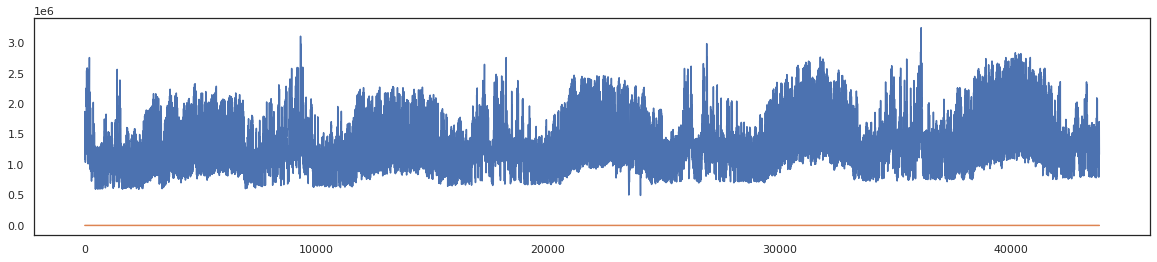

In [40]:
serie1 = df1.Load.tolist()
serie2 = df1.T1.tolist()

plt.figure(figsize=(20, 4))
plt.plot(serie1)
plt.plot(serie2)
npserie1 = np.array(serie1)
len(df)

In [24]:
## ene2010... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·nov2011
##                |                                               |       |           |
##                |                                               |<-n_p->|           |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt   ...j=0...      tf 

n_p       = 1         ## Number of periods per step (Two and half hour)
vsele     = 24        ## Number of periods in a window (a day)
namefile  = 'forecast'
monthyear = 'jun2006'

In [25]:
# >>> provisional para pruebas preliminares (---comentar---)
positions_test = [(0, len(df1), len(df))]  ## Predecir
positions_test

[(0, 43824, 52584)]

In [37]:
positions_test = [(0, 35064, 35250)]  #2006[(0, 35064, 52584)] 

# Multi-period forecast metafunction **II**:

## Test series

In [44]:
## Prepare the test series (real data)
test_ = []
for to,tt,tf in positions_test:
      test_ = test_ + serie1[tt:tf]
print(len(test_))

186


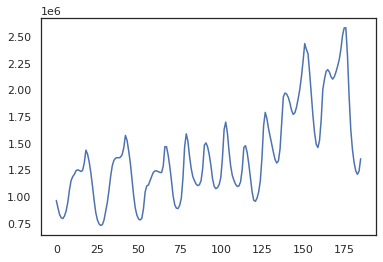

In [45]:
plt.figure()
plt.plot(test_)
plt.show()

In [46]:
## Non-numeric
if False:
  nonumeric=[]
  j   = 0
  aux = 100
  for item in serie1:
    if math.isnan(item):
      nonumeric.append(j)   
      print(j,df_5[serie].index[j],df_5[serie][j])
    j=j+1
  plt.plot(nonumeric)
  #plt.plot(serie1[131640 -aux:131651 +aux])
  #print(df_5[serie].index[0])

## AnMA Analog

In [47]:
timeAn_         = []
forecastAn_     = []
forecastAnMA_   = []
forecastX_An_   = []
forecastX_AnMA_ = []
k               = 5          ## Number of nearest neighbors
tol             = 0.8        ## Closest tolerance percentage between neighbors
typedist        = 'pearson'  ## Distance betweeen neighbors: 'pearson' 'euclidian' 'lb_keogh' 'matrixprofile'
typereg         = 'PCR'      ## Regression model: 'OLSstep' 'Boosting' 'Bagging' 'LinearReg' 'AdaBoost' 'BayesRidge' 'LassoReg' 'RidgeReg' 'PLS' 'PCR' 'VotingEnsemble' 'VotingLinear'
n_p             = n_p        ## Number of periods per step
nfail           = 0
fail_           = False
vsele           = vsele      ## Number of periods in a window

for to,tt,tf in positions_test:
    j=0
    s=n_p
    for i in range(tt,tf,1):
        ## Analogue method parameters
        T_train = numpy.array(serie1[to+j:tt+j])
        L_train = numpy.array(serie2[to+j:tt+j])
        t_o     = time.time()
        try:
            pred_, t_sel_, t_reg_, fail_ = analogo_knn(T_train, L_train, vsele=vsele, k=k, tol=tol, typedist=typedist, typereg=typereg, verbose=False)
        except:
            print("!!! Error has occurred in the position:",tt+j)
        if fail_==True:              
            nfail = nfail + 1
            print(">>> Persistence forecast in position:",tt+j)
        pred_list  = pred_.tolist() 
        forecastAn_ = forecastAn_ + pred_list[0:1]
        print(j)

        timeAn_.append(time.time() - t_o)
        j = j + 1
        s = s + 1
print('>>> Number of forecasts not calculated:', nfail)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
>>> Number of forecasts not calculated: 0


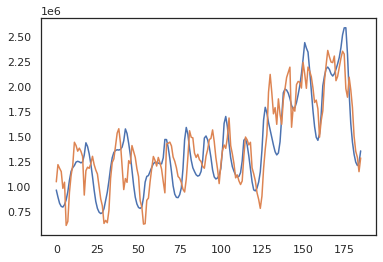

In [48]:
plt.figure()
plt.plot(test_)
plt.plot(forecastAn_)
plt.show()

In [ ]:
if False:
    date_i = df_5.reset_index().iloc[tt].Date
    print('analog:',typereg,typedist)

In [ ]:
df_results = pd.DataFrame({
  'datetime'          : pd.date_range(date_i, periods=len(test_), freq="5T"),
  'Actual'            : test_,
  # 'Persistence'       : forecastp_,
  # 'An '    +typedist+'+'+typereg: forecastAn_,
  # 'AnMA '  +typedist+'+'+typereg: forecastAnMA_,
  # 'HWA '                         : forecastHWA_,
  # 'HWM '                         : forecastHWM_,
  # 'ARIMA '                       : forecastARIMA_,
  'X_An '  +typedist+'+'+typereg: forecastX_An_,
})

df_results = df_results.set_index('datetime')

## Save in csv files
df_results.to_csv(namefile+'_'+serie+'_'+monthyear+'.csv')

plt.figure(figsize=(40, 10))
for c in df_results:
  if c == 'Actual':
    plt.plot(df_results[c], '--', label = c)
  else:
    plt.plot(df_results[c], label = c, alpha=0.8)
plt.legend()
plt.ylabel('demand (MW)')
plt.savefig('series_'+monthyear+'.pdf')
plt.show()

In [ ]:
a=0; b=2000


mae_a  = mean_absolute_error(test_[a:b],forecastAn_)
mape_a = mean_absolute_percentage_error(test_[a:b],forecastAn_[a:b])
bias_a = bias.bias(test_[a:b],forecastAn_[a:b])


In [ ]:
## One-period
d      = typedist
m      = typereg
data   = [diff(test_,forecastp_), diff(test_,forecastAn_), diff(test_,forecastAnMA_),
          diff(test_,forecastHWA_), diff(test_,forecastHWM_),
          ]
labels = ['Persistence', 'An\n('+d+'+'+m+')', 'AnMA\n('+d+'+'+m+')',
                         'HWA',  'HWM',]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "#FF0000"; # 'pink', 'lightblue', 'lightgreen',
#plt.tick_params(colors = LETRASNARA, which='both')
bplot1 = axes.boxplot(data,
                      vert=True,          # vertical box alignment
                      patch_artist=True,  # fill with color
                      labels=labels,)     # will be used to label x-ticks
#axes.set_title('Accuracy',fontsize='x-large',color = LETRASNARA)
#plt.tick_params(colors = LETRASNARA, which='both')
colors = ['pink', 'lightblue', 'lightgreen',LILA, AZUL] # fill with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
axes.yaxis.grid(True) # adding horizontal grid lines
#axes.set_xlabel('Configuraciones de red',fontsize='large',color = LETRASNARA)
axes.set_ylabel('')
namefile = 'boxplot_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

In [ ]:
## Multi-period
d      = typedist
m      = typereg
data   = [ diff(test_,forecastX_An_), diff(test_,forecastX_AnMA_), 
          diff(test_,forecastX_HWA_), diff(test_,forecastX_HWM_),
           diff(test_,forecastX_ARIMA_), #diff(test_,forecastARIMA_),
          ]
labels = [ 'X_An\n('+d+'+'+m+')', 'X_AnMA\n('+d+'+'+m+')',
                          'X_HWA',  'X_HWM', 'X_ARIMA',]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "#FF0000"; # 'pink', 'lightblue', 'lightgreen',
#plt.tick_params(colors = LETRASNARA, which='both')
bplot1 = axes.boxplot(data,
                      vert=True,          # vertical box alignment
                      patch_artist=True,  # fill with color
                      labels=labels,)     # will be used to label x-ticks
#axes.set_title('Accuracy',fontsize='x-large',color = LETRASNARA)
#plt.tick_params(colors = LETRASNARA, which='both')
colors = ['pink', 'lightblue', 'lightgreen',LILA, AZUL] # fill with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
axes.yaxis.grid(True) # adding horizontal grid lines
#axes.set_xlabel('Configuraciones de red',fontsize='large',color = LETRASNARA)
axes.set_ylabel('')
namefile = 'boxplot_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

In [ ]:
plt.plot(timeAn_, label="AnMA")
plt.plot(timeHWA_, label="HWA")
plt.plot(timeHWM_, label="HWM")
plt.plot(timeARIMA_, label="ARIMA")
plt.ylabel('compute seconds')
plt.xlabel('time')
plt.legend(loc="upper left")

print('time_'+monthyear+'.pdf',((np.mean(timeAn_)*8723)/60)/60 )

namefile = 'timeAn_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)

In [ ]:
df_resultados = pd.DataFrame([
  {
    'method': 'Persistence',
    'mape'  : mape_p,
    'mae'   : mae_p, # Conviene normalizar esto (o quitarlo porque normalizado es como el mape)
    'bias'  : bias_p # Conviene normalizar esto
  },
  {
    'method': 'An \n'+d+'+'+m,
    'mape'  : mape_a,
    'mae'   : mae_a, 
    'bias'  : bias_a 
  },
  {
    'method': 'AnMA \n'+d+'+'+m,
    'mape'  : mape_ma,
    'mae'   : mae_ma,
    'bias'  : bias_ma 
  },
  {
    'method': 'HWA\n',
    'mape'  : mape_hwa,
    'mae'   : mae_hwa,
    'bias'  : bias_hwa
  }, 
  {
    'method': 'HWM\n',
    'mape'  : mape_hwm,
    'mae'   : mae_hwm,
    'bias'  : bias_hwm
  }, 
  {
    'method': 'X_An \n'+d+'+'+m,
    'mape'  : mape_xa,
    'mae'   : mae_xa,
    'bias'  : bias_xa 
  },  
  {
    'method': 'X_AnMA \n'+d+'+'+m,
    'mape'  : mape_xma,
    'mae'   : mae_xma,
    'bias'  : bias_xma
  }, 
  {
    'method': 'X_HWA\n',
    'mape'  : mape_xhwa,
    'mae'   : mae_xhwa,
    'bias'  : bias_xhwa
  },
  {
    'method': 'X_HWM\n',
    'mape'  : mape_xhwm,
    'mae'   : mae_xhwm,
    'bias'  : bias_xhwm
  },
  # {
  #   'method': 'X_ARIMA\n',
  #   'mape'  : mape_xarima,
  #   'mae'   : mae_xarima,
  #   'bias'  : bias_xarima
  # },

  # etc.
])
categories = df_resultados.method
N = len(categories)

fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

theta = np.arange(len(df_resultados) + 1) / float(len(df_resultados)) * 2 * np.pi

values = df_resultados.mape.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="MAPE")

values = df_resultados.bias.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="Bias")

plt.xticks(theta[:-1], df_resultados.method, color='grey', size=12)
plt.yticks([0.25, 0.50, 0.75], ['0.25', '0.50', '0.75'], color="grey", size=9)
ax.tick_params(pad=10) # to increase the distance of the labels to the plot

plt.legend(loc='center right', bbox_to_anchor=(0.1, 0.15))

namefile = 'polar_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

# References

*   Jason Brownlee. Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python, (book) 

# To-do

* [ ] Prueba estadística para ver diferencia significativa entre An y AnMA
* [ ] Ajustar el ARIMA
* [ ] Dividir el radial de BIAS y los MAPE en los multi periodo y uni período (pasar a bar plots)
* [ ] Almacenar los resultados en csv
* [ ] Violin plots de error
* [ ] LSTM